<a href="https://colab.research.google.com/github/JuliaKulacz/Fake-News-Detection/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
! pip install transformers

In [77]:
! pip install torch

In [78]:
! pip install pytorch-pretrained-bert

In [79]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

# specify GPU
device = torch.device("cuda")
print(device)

cuda


In [126]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import gensim
import re
import html
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamW
from transformers import AutoModel, BertTokenizerFast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

In [127]:
#DATA

df_train = pd.read_csv("/content/data/train.csv")
df_test = pd.read_csv("/content/data/test.csv")
df_labels = pd.read_csv("/content/data/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

df = df.sample(frac=1)
#Dropping duplicates
df = df.drop_duplicates(subset=['text'])

In [128]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
#removes HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
#removes all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
#removes URLs
    clean = re.sub('\W+',' ', clean)                   
#replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [129]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [130]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

19324    trump campaign admit try steal election voter ...
573                                                       
22077    dennis rodman north korea trip try open door b...
23485    funny anti trump campaign video funny anti tru...
25757    thyroid cancer scare test remove thyroid cance...
                               ...                        
5306     lawmaker approve name officer shoot print city...
6574     secret nazi base treasure hunter discover arct...
1139     comment hillary clinton control agenda expose ...
25853    world community fear hillary kill list world c...
10582    yemeni year guantánamo freedom soul take long ...
Name: clean_joined, Length: 25433, dtype: object


In [131]:
# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [132]:
# Splitting train dataset into train, validation and test sets
x_train, x_temp, y_train, y_temp = train_test_split(df['clean_joined'], df['label'], random_state=2018, test_size=0.3, stratify=df['label'])


x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, random_state=2018, test_size=0.5, stratify=y_temp)

In [133]:
# Tokenizing and encoding sequences
tokens_train = tokenizer.batch_encode_plus( x_train.tolist(), max_length = 25, pad_to_max_length=True, truncation=True)
tokens_val = tokenizer.batch_encode_plus( x_val.tolist(), max_length = 25, pad_to_max_length=True, truncation=True)
tokens_test = tokenizer.batch_encode_plus( x_test.tolist(), max_length = 25, pad_to_max_length=True, truncation=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [134]:
# Converting lists to tensors

train_tokens_tensor = torch.tensor(tokens_train['input_ids'])
train_masks_tensor = torch.tensor(tokens_train['attention_mask'])
train_y_tensor = torch.tensor(y_train.tolist())

val_tokens_tensor = torch.tensor(tokens_val['input_ids'])
val_masks_tensor = torch.tensor(tokens_val['attention_mask'])
val_y_tensor = torch.tensor(y_val.tolist())

test_tokens_tensor = torch.tensor(tokens_test['input_ids'])
test_masks_tensor = torch.tensor(tokens_test['attention_mask'])
test_y_tensor = torch.tensor(y_test.tolist())

# Prepairing dataloaders
batch_size = 32

train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_tokens_tensor, val_masks_tensor, val_y_tensor)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)


In [135]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = True

In [136]:
#BUILDING AND TRAINING MODEL

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
)

# push the model to GPU
model = model.to(device)

In [137]:
# Defining the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)          # lr - learning rate

In [138]:
# Computing the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

print("Class Weights:",class_weights)

# Converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# Pushing weights to GPU
weights = weights.to(device)

# Defining the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

Class Weights: [1.00118097 0.99882181]


In [139]:
# Function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # model predictions
  total_preds=[]

  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # push model predictions to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [140]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [141]:
# number of training epochs
epochs = 2

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    557.
  Batch   100  of    557.
  Batch   150  of    557.
  Batch   200  of    557.
  Batch   250  of    557.
  Batch   300  of    557.
  Batch   350  of    557.
  Batch   400  of    557.
  Batch   450  of    557.
  Batch   500  of    557.
  Batch   550  of    557.

Evaluating...
  Batch    50  of    120.
  Batch   100  of    120.

Training Loss: -7.986
Validation Loss: -12.527

 Epoch 2 / 2
  Batch    50  of    557.
  Batch   100  of    557.
  Batch   150  of    557.
  Batch   200  of    557.
  Batch   250  of    557.
  Batch   300  of    557.
  Batch   350  of    557.
  Batch   400  of    557.
  Batch   450  of    557.
  Batch   500  of    557.
  Batch   550  of    557.

Evaluating...
  Batch    50  of    120.
  Batch   100  of    120.

Training Loss: -14.873
Validation Loss: -17.127


In [142]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_tokens_tensor.to(device), test_masks_tensor.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)

Model accuracy is :  0.9014416775884666
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1905
           1       0.90      0.90      0.90      1910

    accuracy                           0.90      3815
   macro avg       0.90      0.90      0.90      3815
weighted avg       0.90      0.90      0.90      3815



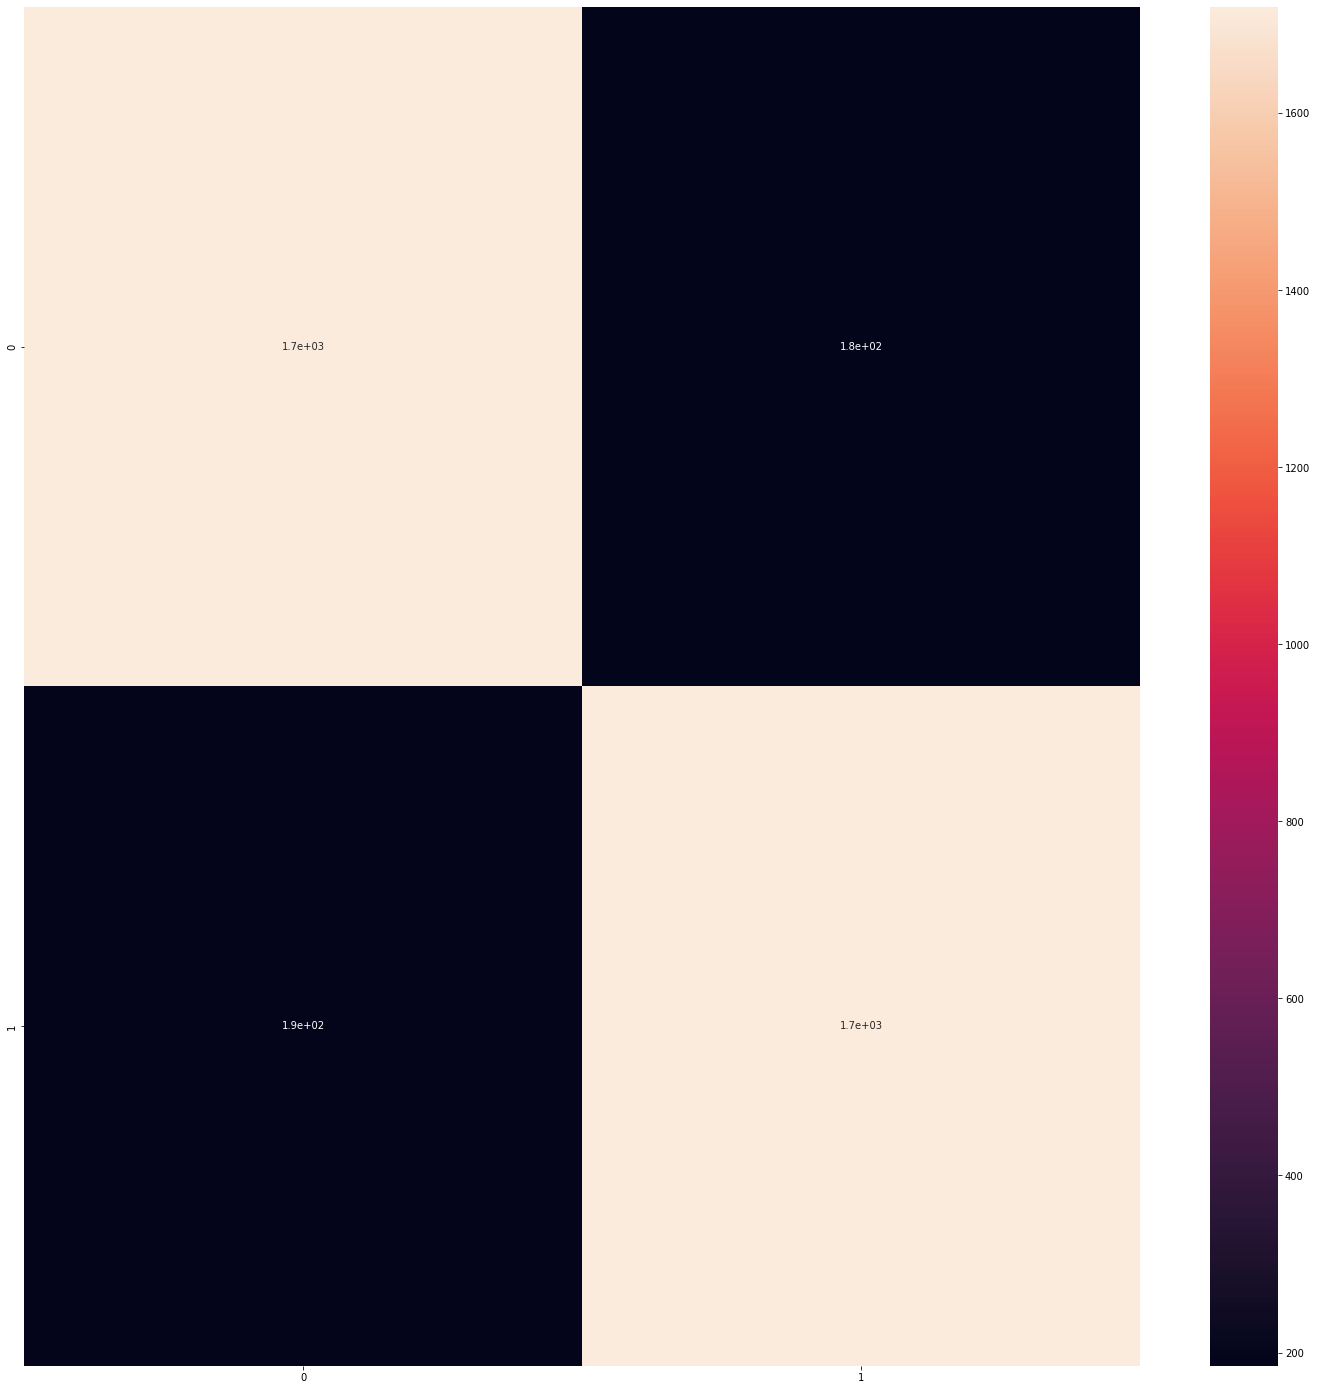

In [143]:
prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(preds)):
    if preds[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()